In [4]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange
import multiprocessing as mp
import timeit
from tqdm import tqdm

In [5]:
ncore = mp.cpu_count()
ncore

64

In [6]:
# need to change
ipts="28402"
# scan_type = 'ct_scans'
scan_type = 'radiographs'

In [7]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/" + scan_type
os.listdir(scan_loc)

['2022_03_03_SYM_LI_high_res',
 '2022_03_04_FUll_LI_2D',
 '2022_03_07_SYM_C_LI_2D',
 '2023_09_07_insitu_60s',
 '2022_03_05_FUll_LI_2D_DIs',
 '2022_03_06_Full_C_LI_2D',
 '2023_09_06_exsitu',
 '2023_09_06_insitu_60s']

In [8]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2022_03_14_stack1',
 '2023_09_08_60s',
 '2022_03_03_SYM_LI_high_res',
 '2022_03_04_FUll_LI_2D',
 '2022_03_08_Ex_Situ_C_LI_CT',
 '2022_03_07_SYM_C_LI_2D',
 '2022_03_15_stack2',
 '2022_03_03_SYM_LI',
 '2022_03_06_Full_C_LI_2D',
 '2023_09_06_insitu_60s',
 '2023_09_06_exsitu_60s']

In [9]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
os.listdir(dc_loc)

['2023_09_08_60s']

In [10]:
###################### need to change start
sample_name = "2023_09_07_insitu_60s"
scan_dir = os.path.join(scan_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2023_09_08_60s")
dc_dir = os.path.join(dc_loc, "2023_09_08_60s")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
gamma_diff = 20
###################### need to change end

# Preprocess CT scan files

In [11]:
fname_list = os.listdir(scan_dir)
# fname_list.pop(0)
fname_list.sort()
fname_list

['20230907_cells_t_discharge_0060_1534.tiff',
 '20230907_cells_t_discharge_0060_1535.tiff',
 '20230907_cells_t_discharge_0060_1536.tiff',
 '20230907_cells_t_discharge_0060_1537.tiff',
 '20230907_cells_t_discharge_0060_1538.tiff',
 '20230907_cells_t_discharge_0060_1539.tiff',
 '20230907_cells_t_discharge_0060_1540.tiff',
 '20230907_cells_t_discharge_0060_1541.tiff',
 '20230907_cells_t_discharge_0060_1542.tiff',
 '20230907_cells_t_discharge_0060_1543.tiff',
 '20230907_cells_t_discharge_0060_1544.tiff',
 '20230907_cells_t_discharge_0060_1545.tiff',
 '20230907_cells_t_discharge_0060_1546.tiff',
 '20230907_cells_t_discharge_0060_1547.tiff',
 '20230907_cells_t_discharge_0060_1548.tiff',
 '20230907_cells_t_discharge_0060_1549.tiff',
 '20230907_cells_t_discharge_0060_1550.tiff',
 '20230907_cells_t_discharge_0060_1551.tiff',
 '20230907_cells_t_discharge_0060_1552.tiff',
 '20230907_cells_t_discharge_0060_1553.tiff',
 '20230907_cells_t_discharge_0060_1554.tiff',
 '20230907_cells_t_discharge_0060_

In [12]:
ob_list = os.listdir(ob_dir)
# fname_list.pop(0)
ob_list.sort()
# ob_list = ob_list[:3]
ob_list

['20230908_OB_0060_2660.tiff',
 '20230908_OB_0060_2661.tiff',
 '20230908_OB_0060_2662.tiff',
 '20230908_OB_0060_2663.tiff',
 '20230908_OB_0060_2664.tiff',
 '20230908_OB_0060_2665.tiff',
 '20230908_OB_0060_2666.tiff',
 '20230908_OB_0060_2667.tiff',
 '20230908_OB_0060_2668.tiff',
 '20230908_OB_0060_2669.tiff']

In [13]:
dc_list = os.listdir(dc_dir)
# fname_list.pop(0)
dc_list.sort()
dc_list

['20230908_DC_0060_2670.tiff',
 '20230908_DC_0060_2671.tiff',
 '20230908_DC_0060_2672.tiff',
 '20230908_DC_0060_2673.tiff',
 '20230908_DC_0060_2674.tiff',
 '20230908_DC_0060_2675.tiff',
 '20230908_DC_0060_2676.tiff',
 '20230908_DC_0060_2677.tiff',
 '20230908_DC_0060_2678.tiff',
 '20230908_DC_0060_2679.tiff',
 '20230908_DC_0060_2680.tiff',
 '20230908_DC_0060_2681.tiff',
 '20230908_DC_0060_2682.tiff',
 '20230908_DC_0060_2683.tiff',
 '20230908_DC_0060_2684.tiff',
 '20230908_DC_0060_2685.tiff',
 '20230908_DC_0060_2686.tiff',
 '20230908_DC_0060_2687.tiff',
 '20230908_DC_0060_2688.tiff',
 '20230908_DC_0060_2689.tiff']

In [14]:
######### Scan
scan_raw = rocku.read_tiff_stack(scan_dir, fname_list)
print(scan_raw.shape)
######### OB
ob_raw = rocku.read_tiff_stack(ob_dir, ob_list)
print(ob_raw.shape)
######### DC
dc_raw = rocku.read_tiff_stack(dc_dir, dc_list)
print(dc_raw.shape)

88it [01:19,  1.11it/s]


KeyboardInterrupt: 

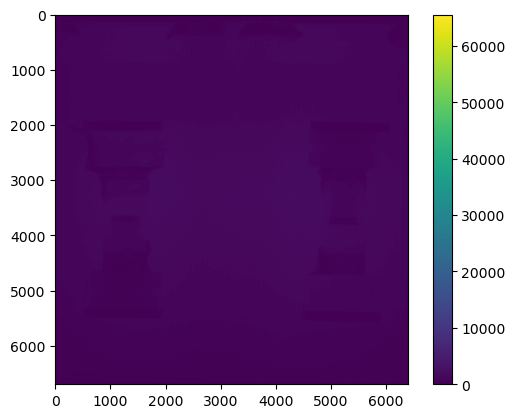

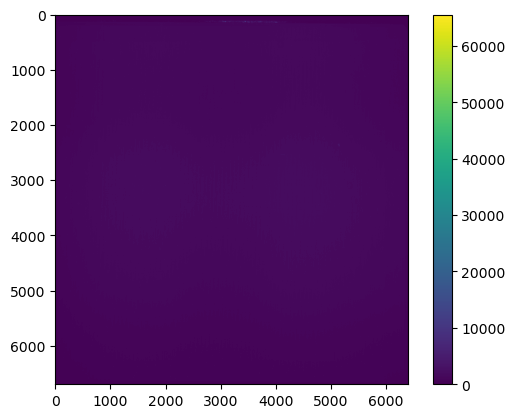

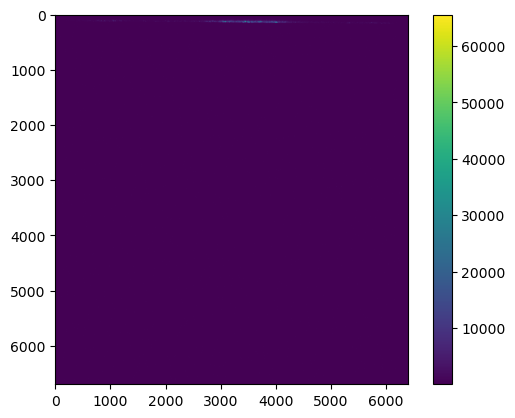

In [98]:
scan_min = np.min(scan_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(scan_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Crop ROI

Recon ROI:


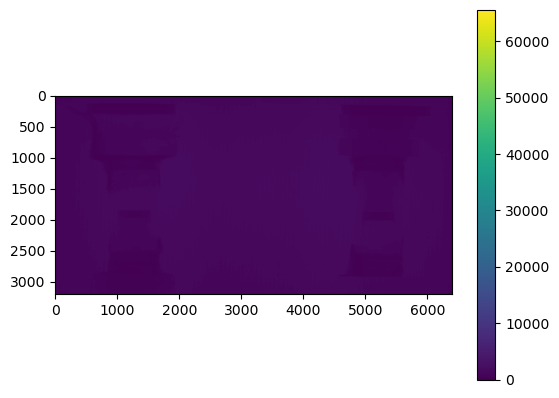

In [100]:
###################### need to change start
crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 0
crop_right = 7000
crop_top = 1800
crop_bottom = 5000
###################### need to change end
scan_crop = rocku.crop(scan_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
scan_crop_min = rocku.crop(scan_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(scan_crop_min)
plt.colorbar()
plt.show()

# Removal outliers

In [101]:
t0 = timeit.default_timer()
scan_crop = tomopy.misc.corr.remove_outlier(scan_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 313.9412741959095 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...


/SNS/users/y9z/Documents/GitHub/research_stuff/jupyter_notebooks/norm_recon/utilities.py:358: RuntimeWarning: divide by zero encountered in divide
  proj_norm = np.true_divide(_proj, _ob, dtype=np.float32)
/SNS/users/y9z/Documents/GitHub/research_stuff/jupyter_notebooks/norm_recon/utilities.py:358: RuntimeWarning: invalid value encountered in divide
  proj_norm = np.true_divide(_proj, _ob, dtype=np.float32)


Normalization Done!
float32
(1125, 3200, 6400)


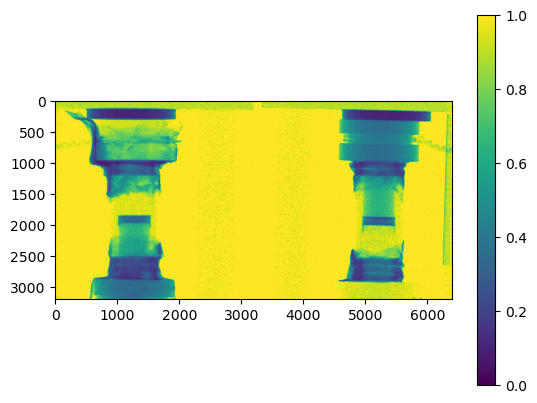

In [102]:
scan_norm, ob_med, dc_med = rocku.normalize(scan_crop, ob_crop, dc_crop)
print(scan_norm.dtype)
print(scan_norm.shape)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Beam fluctuation correction (optional)


Beam fluctuation ROI:


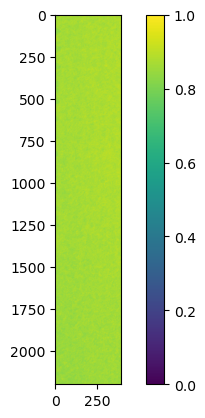

In [103]:
###################### need to change start
bg_left = 110
bg_right = 500
bg_top = 800
bg_bottom = 3000
###################### need to change end
bg_stack = scan_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [104]:
t0 = timeit.default_timer()
scan_norm = tomopy.prep.normalize.normalize_roi(scan_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

OSError: [Errno 12] Cannot allocate memory

# Save files

In [40]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/normalized/" + sample_name
for i, e_name in enumerate(fname_list):
#     e_name = rocku.remove_1st_str(e_name)
    fname = save_to + "/" + e_name
    print('Saving to {} ...'.format(fname))
    dxchange.write_tiff(scan_norm[i], fname=fname, overwrite=True)
# dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)
# print('Combining with median ...')
# scan_med = np.median(scan_norm, axis=0)
# print(scan_med.dtype)
# dxchange.write_tiff(scan_med, fname=save_to + "/MED", overwrite=True)
# dxchange.write_tiff(ob_med, fname=save_to + "/OB_DC", overwrite=True)
# dxchange.write_tiff(dc_med, fname=save_to + "/DC", overwrite=True)

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0342.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0343.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0344.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0345.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0346.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0347.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0348.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t0_0060_0349.tiff ...
Saving t

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0406.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0407.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0408.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0409.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0410.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0411.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0412.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0469.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0470.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0471.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0472.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0473.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0474.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0475.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0532.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0533.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0534.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0535.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0536.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0537.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0538.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0595.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0596.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0597.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0598.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0599.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0600.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0601.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0658.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0659.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0660.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0661.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0662.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0663.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0664.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0721.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0722.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0723.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0724.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0725.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0726.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230906_cells_t_cycling_0060_0727.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0784.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0785.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0786.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0787.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0788.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0789.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0790.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0847.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0848.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0849.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0850.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0851.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0852.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0853.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0910.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0911.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0912.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0913.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0914.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0915.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0916.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0973.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0974.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0975.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0976.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0977.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0978.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_0979.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1036.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1037.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1038.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1039.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1040.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1041.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1042.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1099.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1100.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1101.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1102.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1103.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1104.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1105.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1162.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1163.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1164.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1165.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1166.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1167.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1168.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1225.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1226.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1227.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1228.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1229.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1230.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1231.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1288.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1289.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1290.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1291.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1292.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1293.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1294.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1351.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1352.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1353.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1354.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1355.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1356.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1357.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1414.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1415.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1416.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1417.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1418.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1419.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1420.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1477.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1478.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1479.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1480.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1481.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1482.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s/20230907_cells_t_cycling_0060_1483.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_

# Bin files

In [91]:
len(fname_list)

1190

In [92]:
bin_size = 5
fname_list_bin = fname_list[0::bin_size]
fname_list_bin

['20230906_cells_t0_0060_0342.tiff',
 '20230906_cells_t0_0060_0347.tiff',
 '20230906_cells_t_cycling_0060_0352.tiff',
 '20230906_cells_t_cycling_0060_0357.tiff',
 '20230906_cells_t_cycling_0060_0362.tiff',
 '20230906_cells_t_cycling_0060_0367.tiff',
 '20230906_cells_t_cycling_0060_0372.tiff',
 '20230906_cells_t_cycling_0060_0377.tiff',
 '20230906_cells_t_cycling_0060_0382.tiff',
 '20230906_cells_t_cycling_0060_0387.tiff',
 '20230906_cells_t_cycling_0060_0392.tiff',
 '20230906_cells_t_cycling_0060_0397.tiff',
 '20230906_cells_t_cycling_0060_0402.tiff',
 '20230906_cells_t_cycling_0060_0407.tiff',
 '20230906_cells_t_cycling_0060_0412.tiff',
 '20230906_cells_t_cycling_0060_0417.tiff',
 '20230906_cells_t_cycling_0060_0422.tiff',
 '20230906_cells_t_cycling_0060_0427.tiff',
 '20230906_cells_t_cycling_0060_0432.tiff',
 '20230906_cells_t_cycling_0060_0437.tiff',
 '20230906_cells_t_cycling_0060_0442.tiff',
 '20230906_cells_t_cycling_0060_0447.tiff',
 '20230906_cells_t_cycling_0060_0452.tiff',
 '

In [93]:
len(scan_norm)

1190

In [94]:
scan_norm_binned = np.array([np.mean(scan_norm[i:i+10], axis=0) for i in tqdm(range(0, len(scan_norm), bin_size))]) 

100%|█████████████████████████████████████████| 238/238 [00:48<00:00,  4.94it/s]


In [95]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/normalized/" + sample_name + "_binned_by_" + str(bin_size)
for i, e_name in enumerate(fname_list_bin):
#     e_name = rocku.remove_1st_str(e_name)
    fname = save_to + "/" + e_name
    print('Saving to {} ...'.format(fname))
    dxchange.write_tiff(scan_norm_binned[i], fname=fname, overwrite=True)

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t0_0060_0342.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t0_0060_0347.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0352.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0357.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0362.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0367.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0372.tiff ...
Saving to /HF

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0632.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0637.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0642.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0647.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0652.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0657.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230906_cells_t_cycling_0060_0662.tiff ...

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_0922.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_0927.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_0932.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_0937.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_0942.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_0947.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_0952.tiff ...

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1212.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1217.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1222.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1227.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1232.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1237.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1242.tiff ...

Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1502.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1507.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1512.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1517.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1522.tiff ...
Saving to /HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5/20230907_cells_t_cycling_0060_1527.tiff ...
